# Experimento 1

Basado en los notebooks proporcionados en los siguientes enlaces:


*   [pykan/.../tutorials/Example/Example_1_function_fitting](https://github.com/KindXiaoming/pykan/blob/master/tutorials/Example/Example_1_function_fitting.ipynb)
*   [pykan/hellokan.ipynb](https://github.com/KindXiaoming/pykan/blob/master/hellokan.ipynb)



El teorema de representación de Kolmogorov-Arnold establece que si $f$ es una función continua multivariada en un dominio acotado, entonces se puede escribir como una composición finita de funciones continuas de una sola variable y la operación binaria de suma.

Por lo tanto, dada $f : [0,1]^n \to \mathbb{R}$ cumpliendo ciertas condiciones,


 $$f(x) = f(x_1,...,x_n)=\sum_{q=1}^{2n+1}\Phi_q(\sum_{p=1}^n \phi_{q,p}(x_p))$$

 donde $\phi_{q,p}:[0,1]\to\mathbb{R}$ y $\Phi_q:\mathbb{R}\to\mathbb{R}$.

 En cierto sentido, el KART indica que la única operación multivariada verdadera es la operación suma, ya que cualquier otra función puede escribirse usando funciones univariadas y la suma.

 Sin embargo, esta representación de Kolmogorov-Arnold de 2 capas de ancho $(2n+1)$ puede no ser suave debido a su limitada capacidad expresiva.

 En liu et al. (2024) se aumenta su capacidad expresiva generalizándola a profundidades y anchos arbitrarios.


##Instalación de pykan

In [42]:
!pip install pykan


## Configuración de torch, device y generación de modelo base

In [43]:
from kan import *
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


## Creación del dataset

Se genera un conjunto de datos conformado con las evaluaciones de una función en una serie de valores de sus variables de entrada. La función create_dataset nos genera un conjunto de 1000 valores de entrenamiento y de etiquetas de entrenamiento asociadas.

In [44]:
from kan.utils import create_dataset
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

## Inicialización del modelo

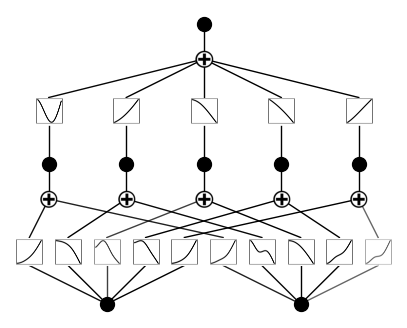

In [45]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot()

## Entrenamiento inicial

In [46]:
# train the model
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

| train_loss: 1.91e-02 | test_loss: 1.87e-02 | reg: 5.86e+00 | : 100%|█| 50/50 [00:33<00:00,  1.50it

saving model version 0.1


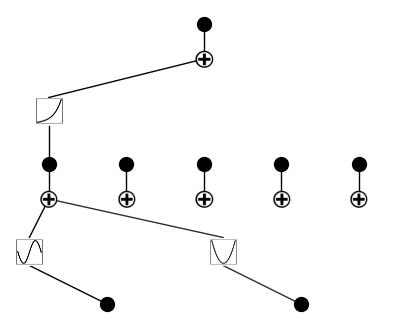

In [47]:
model.plot()

## Poda del modelo

saving model version 0.2


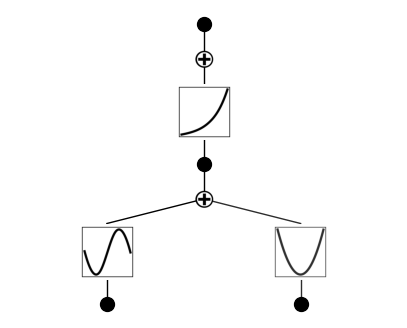

In [48]:
model = model.prune()
model.plot()

## Entrenamiento modelo podado

In [49]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 1.77e-02 | test_loss: 1.71e-02 | reg: 7.97e+00 | : 100%|█| 50/50 [00:09<00:00,  5.21it

saving model version 0.3


## Refinamos el grid del modelo

In [50]:
model = model.refine(10)

saving model version 0.4


## Entrenamiento modelo refinado

In [51]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 4.67e-04 | test_loss: 4.72e-04 | reg: 7.95e+00 | : 100%|█| 50/50 [00:11<00:00,  4.49it

saving model version 0.5


## Obtención de la expresión simbólica

In [52]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999999196339869, c=2
fixing (0,1,0) with x^2, r2=0.9999999815180409, c=2
fixing (1,0,0) with exp, r2=0.999999991045606, c=2
saving model version 0.6


## Último entrenamiento para conseguir precisión máquina

In [53]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 8.92e-09 | test_loss: 9.56e-09 | reg: 0.00e+00 | : 100%|█| 50/50 [00:03<00:00, 12.98it

saving model version 0.7


## Expresión final redondeada

In [54]:
from kan.utils import ex_round

ex_round(model.symbolic_formula()[0][0],4)

1.0*exp(1.0*x_2**2 + 1.0*sin(3.1416*x_1))

## Ejemplo original [Example_3: Deep Formula](https://github.com/KindXiaoming/pykan/blob/master/tutorials/Example/Example_3_deep_formula.ipynb)

In [55]:
import torch
from kan import KAN, create_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[4,2,1,1], grid=3, k=3, seed=1, device=device)
f = lambda x: torch.exp((torch.sin(torch.pi*(x[:,[0]]**2+x[:,[1]]**2))+torch.sin(torch.pi*(x[:,[2]]**2+x[:,[3]]**2)))/2)
dataset = create_dataset(f, n_var=4, train_num=3000, device=device)

# train the model
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.002, lamb_entropy=2.);

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.27e-01 | test_loss: 4.27e-01 | reg: 8.69e+00 | : 100%|█| 20/20 [00:16<00:00,  1.25it

saving model version 0.1


In [56]:
model = model.prune(edge_th=1e-2)

saving model version 0.2


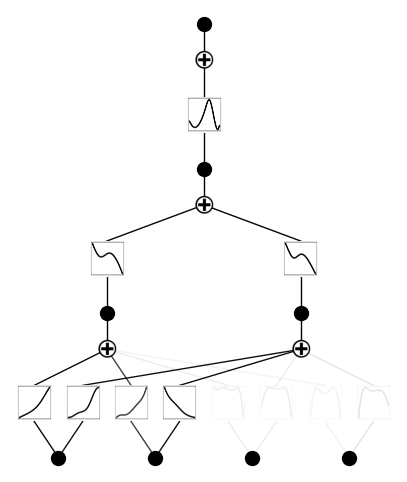

In [57]:
model.plot()

In [58]:
grids = [3,5,10,20,50]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    #model = KAN(width=[4,9,1], grid=grids[i], k=3, seed=0).initialize_from_another_model(model, dataset['train_input'])
    #model = KAN(width=[4,2,1,1], grid=grids[i], k=3, seed=0, device=device).initialize_from_another_model(model, dataset['train_input'])
    model = model.refine(grids[i])
    results = model.fit(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30);
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

saving model version 0.3


| train_loss: 4.24e-01 | test_loss: 4.26e-01 | reg: 8.12e+00 | : 100%|█| 50/50 [00:33<00:00,  1.48it


saving model version 0.4
saving model version 0.5


| train_loss: 4.08e-01 | test_loss: 4.18e-01 | reg: 8.24e+00 | : 100%|█| 50/50 [00:35<00:00,  1.42it


saving model version 0.6
saving model version 0.7


| train_loss: 3.90e-01 | test_loss: 4.18e-01 | reg: 8.31e+00 | : 100%|█| 50/50 [00:45<00:00,  1.10it


saving model version 0.8
saving model version 0.9


| train_loss: 3.70e-01 | test_loss: 4.19e-01 | reg: 8.36e+00 | : 100%|█| 50/50 [01:05<00:00,  1.32s/


saving model version 0.10
saving model version 0.11


| train_loss: 4.38e-01 | test_loss: 4.90e-01 | reg: 8.89e+00 | : 100%|█| 50/50 [02:09<00:00,  2.59s/

saving model version 0.12


[0.42420054188698536, 0.40765020936087626, 0.3904344010078651, 0.37036665036994926, 0.4380128988299456]
[0.42577354029185804, 0.41803512363141454, 0.417853795633392, 0.41876790949058396, 0.49039746704016474]


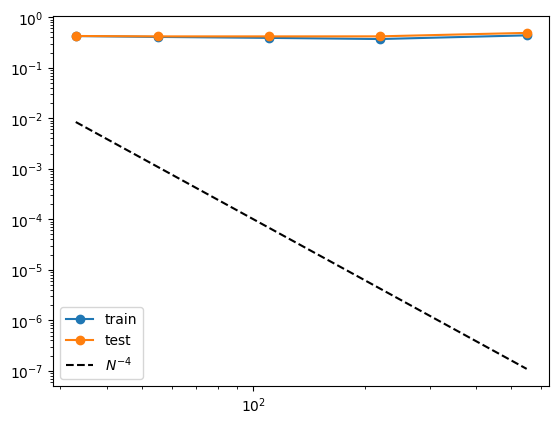

In [59]:
import numpy as np
import matplotlib.pyplot as plt

n_params = np.array(grids) * (4*2+2*1+1*1)
plt.plot(n_params, train_rmse, marker="o")
plt.plot(n_params, test_rmse, marker="o")
plt.plot(n_params, 10000*n_params**(-4.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
print(train_rmse)
print(test_rmse)

### NOTA

Como vemos en Colab tampoco hemos podido reproducir la ejecución original.


In [60]:
ode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.5432413750953414, c=1
fixing (0,0,1) with x, r2=0.8303854847593312, c=1
fixing (0,1,0) with x, r2=0.2354659747948559, c=1
fixing (0,1,1) with x, r2=0.9605595591624128, c=1
fixing (0,2,0) with x, r2=0.11883989166341039, c=1
fixing (0,2,1) with x, r2=0.3818748641462514, c=1
fixing (0,3,0) with x, r2=0.18232440972971767, c=1
fixing (0,3,1) with x, r2=0.0003267722237788114, c=1
fixing (1,0,0) with x, r2=0.08294860298550222, c=1
fixing (1,1,0) with x, r2=0.1621844476093813, c=1
fixing (2,0,0) with x, r2=0.8980994369409087, c=1
saving model version 0.13


In [61]:
# Fórmula simbólica obtenida por el modelo

ex_round(model.symbolic_formula()[0][0],4)

-0.0398*x_1 + 0.1187*x_2 - 0.0458*x_3 + 0.0242*x_4 + 1.5803